In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from torch.utils.data import DataLoader, Subset

BATCH_SIZE = 64  # Increase batch size for better training
NUM_WORKERS = 4
DATA_DIR = "data"

# ========================
# 2. DATA LOADING (WITH STRONG AUGMENTATION)
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CelebA(root=DATA_DIR,
                       split="train",
                       transform=transform,
                       download=True,
                       target_type="attr")
val_dataset = CelebA(root=DATA_DIR,
                     split="valid",
                     transform=transform,
                     download=True,
                     target_type="attr")

train_labels = train_dataset.attr
val_labels = val_dataset.attr

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=NUM_WORKERS)


Files already downloaded and verified
Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)

Using device: cuda


['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


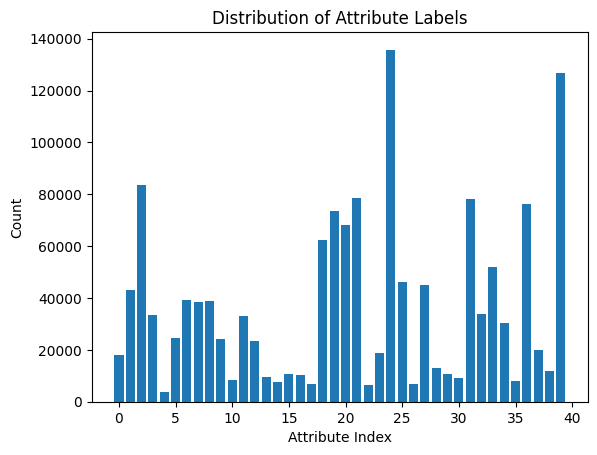

In [ ]:
# 1 identify labels of attributes
#attribute_labels =
print(train_dataset.attr_names)
# print histogram of labels
import matplotlib.pyplot as plt

import numpy as np

subset_targets = train_labels
counts = np.sum(subset_targets.numpy(), axis=0)
counts
# plot bar chart of counts
plt.bar(range(len(counts)), counts)
plt.xlabel("Attribute Index")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.show()

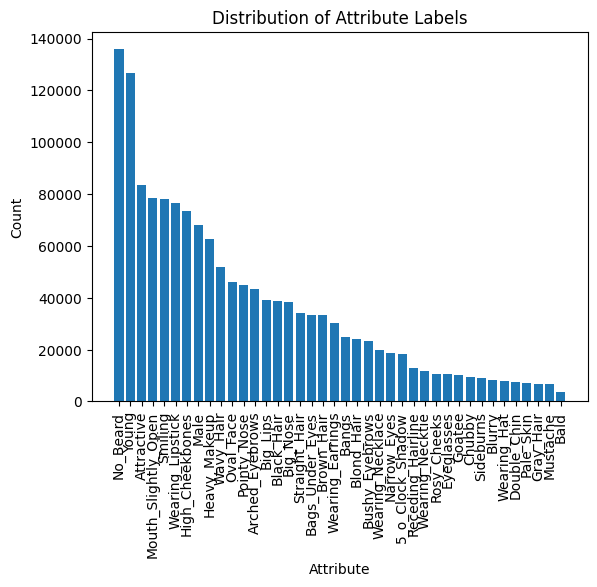

In [ ]:
attribute_to_count = {
    train_dataset.attr_names[i]: counts[i]
    for i in range(len(counts))
}
# Sort attributes by count
sorted_attributes = sorted(attribute_to_count.items(),
                           key=lambda x: x[1],
                           reverse=True)
# Print sorted attributes
#for attr, count in sorted_attributes:
#    print(f"{attr}: \t\t {count}")
# plot sorted attributes with counts, with text annotainos
x_axis = [attr for attr, count in sorted_attributes]
y_axis = [count for attr, count in sorted_attributes]
plt.bar(x_axis, y_axis)
plt.xlabel("Attribute")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.xticks(rotation=90)
plt.show()

In [8]:
subset_targets_np = subset_targets.numpy()

correlation_matrix = np.corrcoef(subset_targets_np, rowvar=False)
correlation_matrix.shape

(40, 40)

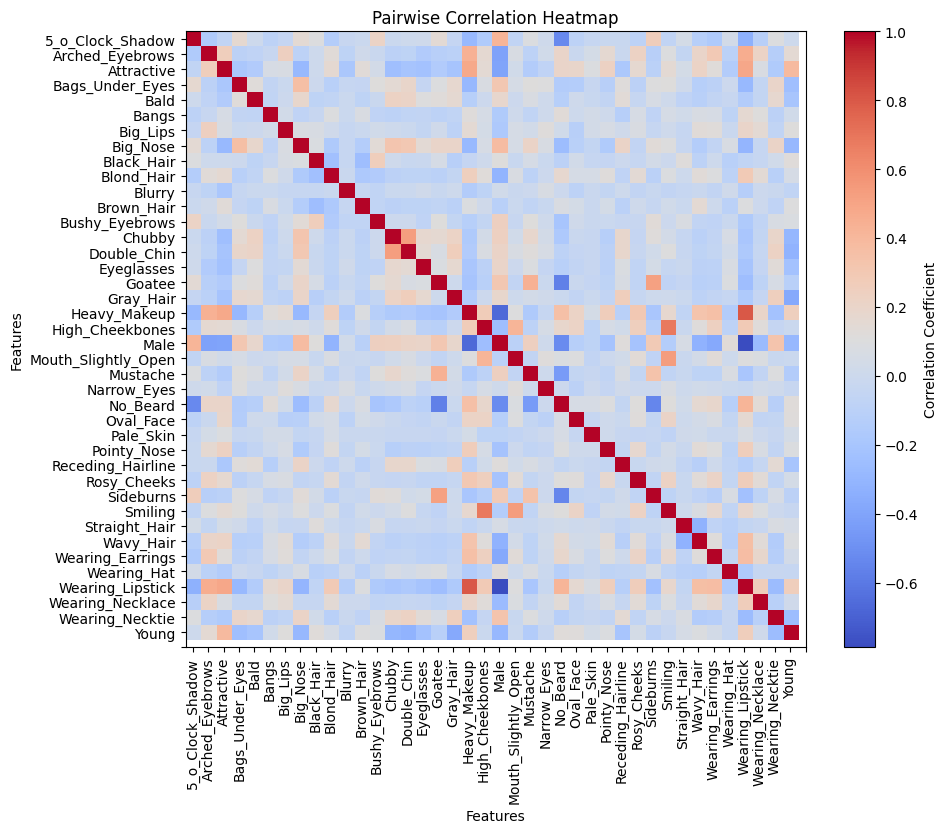

In [ ]:
import matplotlib.pyplot as plt

attr_names = train_dataset.attr_names

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Correlation Coefficient")

# Set x and y ticks
plt.xticks(ticks=range(len(attr_names)), labels=attr_names, rotation=90)
plt.yticks(ticks=range(len(attr_names)), labels=attr_names)

plt.title("Pairwise Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()


In [ ]:
average_correlation = np.mean(correlation_matrix, axis=1)
attribute_to_correlation = {
    train_dataset.attr_names[i]: correlation_matrix[i]
    for i in range(len(correlation_matrix))
}
# Sort attributes by average correlation
sorted_attributes = sorted(attribute_to_correlation.items(),
                           key=lambda x: np.mean(x[1]),
                           reverse=True)
# Print sorted attributes
for attr, correlation in sorted_attributes:
    print(f"{attr}: \t\t {np.mean(correlation):.4f}")

Smiling: 		 0.0922
High_Cheekbones: 		 0.0876
Mouth_Slightly_Open: 		 0.0688
Rosy_Cheeks: 		 0.0649
Heavy_Makeup: 		 0.0610
Arched_Eyebrows: 		 0.0598
Wearing_Lipstick: 		 0.0555
Wearing_Earrings: 		 0.0549
Big_Lips: 		 0.0544
Double_Chin: 		 0.0529
Big_Nose: 		 0.0521
Chubby: 		 0.0496
Wearing_Necklace: 		 0.0466
Attractive: 		 0.0418
Narrow_Eyes: 		 0.0376
Oval_Face: 		 0.0354
Pointy_Nose: 		 0.0354
Bags_Under_Eyes: 		 0.0346
Wavy_Hair: 		 0.0344
Mustache: 		 0.0330
Receding_Hairline: 		 0.0326
Bushy_Eyebrows: 		 0.0307
Bald: 		 0.0305
Wearing_Necktie: 		 0.0292
Goatee: 		 0.0270
Gray_Hair: 		 0.0253
Blond_Hair: 		 0.0252
Sideburns: 		 0.0225
Bangs: 		 0.0207
Black_Hair: 		 0.0177
Pale_Skin: 		 0.0154
Straight_Hair: 		 0.0089
Eyeglasses: 		 0.0071
Brown_Hair: 		 0.0032
5_o_Clock_Shadow: 		 0.0021
Young: 		 -0.0009
No_Beard: 		 -0.0043
Wearing_Hat: 		 -0.0077
Blurry: 		 -0.0090
Male: 		 -0.0231


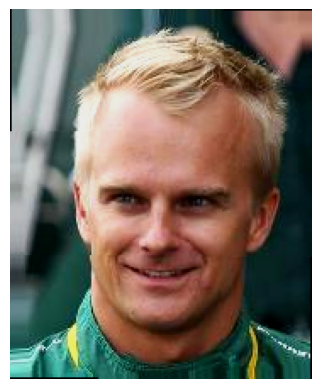

In [ ]:
def get_embedding(model, x):
    """
    Extract embedding from the second-to-last layer of ResNet50.
    """
    with torch.no_grad():
        features = model(x)
        features = features.squeeze(-1).squeeze(
            -1)  # Remove unnecessary dimensions
    return features


# Example usage

import torch
import torch.nn as nn


def get_nth_to_last_embedding(model, x, n=2):
    """
    Extract embedding from the n-th to last layer of ResNet.
    Args:
        model: ResNet model (e.g., ResNet50)
        x: Input image tensor (batch_size, 3, H, W)
        n: Number of layers to remove from the end (default: 2 for second-to-last layer)
    Returns:
        features: Extracted feature tensor
    """
    # Get model layers except last n layers
    truncated_model = nn.Sequential(*list(model.children())[:-n])

    with torch.no_grad():
        features = truncated_model(x)  # Pass input through the truncated model
        features = features.squeeze(-1).squeeze(
            -1)  # Remove unnecessary dimensions

    return features


# Example usage:
# x = torch.randn(1, 3, 224, 224).to(device)  # Example input
# embedding = get_nth_to_last_embedding(model, x, n=2)  # Extract second-to-last layer
# print(embedding.shape)

get_embedding = lambda model, x: get_nth_to_last_embedding(model, x, n=1)

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch


def show_image(tensor_img):
    """
    Displays an image from a tensor.
    """
    if isinstance(tensor_img, torch.Tensor):
        tensor_img = tensor_img.permute(
            1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Normalize range from [-1, 1] to [0, 1] if needed
    tensor_img = (tensor_img *
                  0.5) + 0.5  # Assuming CelebA normalization [-1,1] -> [0,1]
    tensor_img = tensor_img.clip(0, 1)

    plt.imshow(tensor_img)
    plt.axis("off")
    plt.show()


# Example usage
index = 12  # Change index as needed
img_tensor = train_dataset[index][0]  # Get image tensor
show_image(img_tensor)


# generate PCAs/linear probes on different model embeddings

In [ ]:
from pathlib import Path

SAVE_DIR = Path(
    "/n/home04/rrinberg/code/data_to_concept_unlearning/notebooks/models")

original_model_path = SAVE_DIR / "resnet50_scratch_celeba.pth"
attr_index = 3
model_without_attr_path = SAVE_DIR / f"resnet50_celeba__remove_{attr_index}.pth"
if not original_model_path.exists():
    raise FileNotFoundError(
        f"Original model not found at {original_model_path}")


def load_model(model_path):
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 40)  # Adjust for CelebA
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    return model


original_model = load_model(original_model_path)
model_without_attr = load_model(model_without_attr_path)


Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
-----2-----
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
Accuracy of logistic regression on embeddings for with_attr: 0.3675
embedding shape (2000, 2048)
n 1000


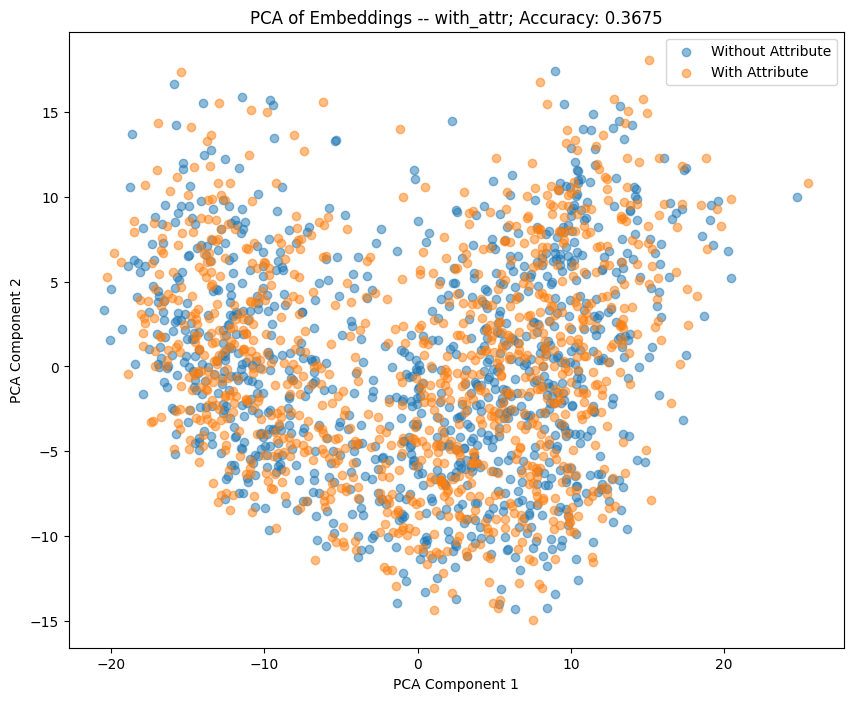

Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
-----2-----
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
Accuracy of logistic regression on embeddings for without_attr: 0.4200
embedding shape (2000, 2048)
n 1000


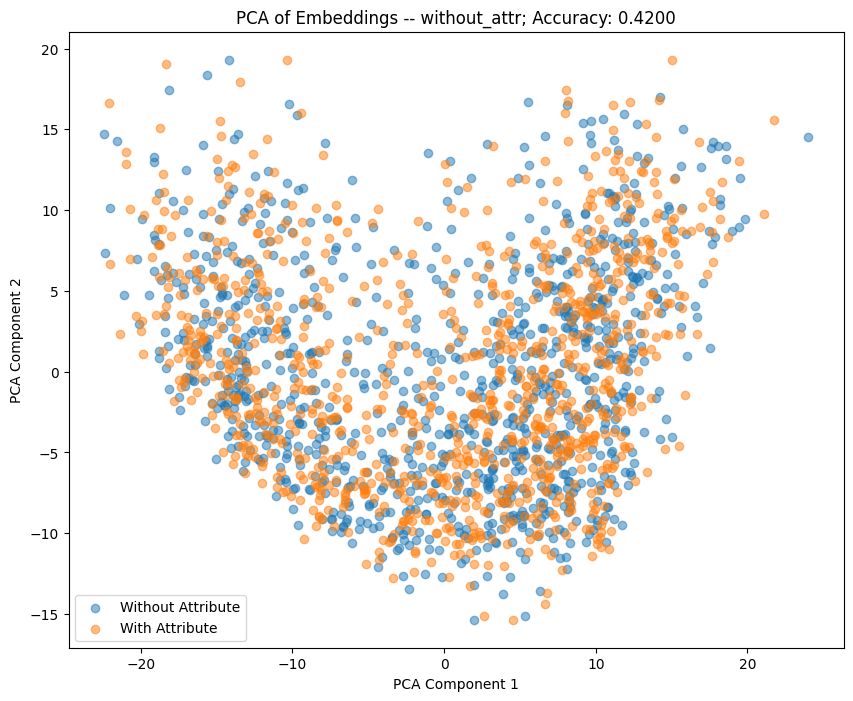

In [ ]:
cpu_device = torch.device("cpu")

models = [("with_attr", original_model), ("without_attr", model_without_attr)]
for name, model_ in models:
    indices_without_attr = np.where(subset_targets_np[:, attr_index] == 0)[0]
    indices_with_attr = np.where(subset_targets_np[:, attr_index] == 1)[0]

    num_images = 1000
    # Get embeddings for images without attribute
    embeddings_without_attr = []
    for ii, idx in enumerate(indices_without_attr[:num_images]):
        if ii % 50 == 0:
            print("Processing sample", ii)
        img_tensor = train_dataset[idx][0].unsqueeze(0).to(
            cpu_device)  # Add batch dimension
        embedding = get_embedding(model_.to(cpu_device), img_tensor)
        embeddings_without_attr.append(embedding.cpu().numpy())
    print("-----2-----")
    # Get embeddings for images with attribute
    embeddings_with_attr = []
    for ii, idx in enumerate(indices_without_attr[:num_images]):
        if ii % 50 == 0:
            print("Processing sample", ii)
        img_tensor = train_dataset[idx][0].unsqueeze(0).to(
            cpu_device)  # Add batch dimension
        embedding = get_embedding(model_.to(cpu_device), img_tensor)
        embeddings_with_attr.append(embedding.cpu().numpy())
    all_embeddings = embeddings_without_attr + embeddings_with_attr
    # stack
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    labels_ = np.concatenate([
        np.zeros(len(embeddings_without_attr)),
        np.ones(len(embeddings_with_attr))
    ])

    # train logistic regression on embeddings and labels
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import train_test_split
    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(all_embeddings,
                                                        labels_,
                                                        test_size=0.2,
                                                        random_state=42)
    # train logistic regression
    logreg = LogisticRegression(max_iter=1000, solver="liblinear")
    logreg.fit(X_train, y_train)
    preds = logreg.predict(X_test)
    acc = accuracy_score(y_test, preds)

    #acc = accuracy_score(labels_, preds)
    print(
        f"Accuracy of logistic regression on embeddings for {name}: {acc:.4f}")
    print(f"embedding shape {all_embeddings.shape}")
    n = len(embeddings_with_attr)
    print(f"n {n}")
    # run PCA on embeddings
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import numpy as np
    #embeddings_without_attr_np = np.concatenate(embeddings_without_attr, axis=0)
    #embeddings_with_attr_np = np.concatenate(embeddings_with_attr, axis=0)
    #embeddings_with_attr_np.shape
    # plot embeddings with PCA
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(all_embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_embeddings[:n, 0],
                pca_embeddings[:n, 1],
                label="Without Attribute",
                alpha=0.5)
    plt.scatter(pca_embeddings[n:, 0],
                pca_embeddings[n:, 1],
                label="With Attribute",
                alpha=0.5)
    plt.title(f"PCA of Embeddings -- {name}; Accuracy: {acc:.4f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()
